# Dataset Description
In this competition, you will predict sales for the thousands of product families sold at Favorita stores located in Ecuador. The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building your models.

# File Descriptions and Data Field Information
## train.csv  
- The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
- store_nbr identifies the store at which the products are sold.
- family identifies the type of product sold.
- sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
- onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.
## test.csv  
- The test data, having the same features as the training data. You will predict the target sales for the dates in this file.
- The dates in the test data are for the 15 days after the last date in the training data.
## sample_submission.csv  
- A sample submission file in the correct format.
## stores.csv  
- Store metadata, including city, state, type, and cluster.
- cluster is a grouping of similar stores.
## oil.csv  
- Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)
## holidays_events.csv  
- Holidays and Events, with metadata
- NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
- Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).
## Additional Notes  
- Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
- A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

# Import Packages

In [1]:
import glob
import os
import warnings
from matplotlib import style

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import lightgbm as lgb
from sklearn.metrics import mean_squared_log_error

In [2]:
style.use('dark_background')   # let graphs clear in the dark background of VScode
plt.rcParams['font.sans-serif']=['SimHei']   # Avoid abnormal display of Chineses Lables 
plt.rcParams['axes.unicode_minus'] = False   # Avoid abnormal dsiplay of '-'
pd.set_option('mode.chained_assignment', None)
warnings.filterwarnings("ignore")

# Load Data

In [3]:
path = 'input/store-sales-time-series-forecasting/' 

df_hoilday = pd.read_csv(path + 'holidays_events.csv')
df_oil = pd.read_csv(path + 'oil.csv')
df_store = pd.read_csv(path + 'stores.csv')
df_transaction = pd.read_csv(path + 'transactions.csv')

df_train = pd.read_csv(path + 'train.csv')
df_test = pd.read_csv(path + 'test.csv')

df_name = ['df_hoilday', 'df_oil', 'df_store', 'df_transaction', 'df_train', 'df_test']


# EDA

## hoilday

In [4]:
df_hoilday.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [5]:
df_hoilday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [6]:
df_hoilday.describe()

,date,type,locale,locale_name,description,transferred
count,350,350,350,350,350,350
unique,312,6,3,24,103,2
top,2014-06-25,Holiday,National,Ecuador,Carnaval,False
freq,4,221,174,174,10,338


In [7]:
df_hoilday[df_hoilday['transferred']== True]

,date,type,locale,locale_name,description,transferred
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
72,2013-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
135,2014-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
255,2016-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
266,2016-07-25,Holiday,Local,Guayaquil,Fundacion de Guayaquil,True
268,2016-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True
297,2017-01-01,Holiday,National,Ecuador,Primer dia del ano,True
303,2017-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,True
312,2017-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
324,2017-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True


In [8]:
df_hoilday[df_hoilday['type']== 'Transfer']

,date,type,locale,locale_name,description,transferred
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
73,2013-10-11,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
136,2014-10-10,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
256,2016-05-27,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False
265,2016-07-24,Transfer,Local,Guayaquil,Traslado Fundacion de Guayaquil,False
269,2016-08-12,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False
298,2017-01-02,Transfer,National,Ecuador,Traslado Primer dia del ano,False
304,2017-04-13,Transfer,Local,Cuenca,Fundacion de Cuenca,False
313,2017-05-26,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False
325,2017-08-11,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False


In [9]:
df_hoilday[df_hoilday['type']== 'Bridge']

,date,type,locale,locale_name,description,transferred
35,2012-12-24,Bridge,National,Ecuador,Puente Navidad,False
39,2012-12-31,Bridge,National,Ecuador,Puente Primer dia del ano,False
156,2014-12-26,Bridge,National,Ecuador,Puente Navidad,False
160,2015-01-02,Bridge,National,Ecuador,Puente Primer dia del ano,False
277,2016-11-04,Bridge,National,Ecuador,Puente Dia de Difuntos,False


In [10]:
df_hoilday[df_hoilday['type']== 'Work Day']

,date,type,locale,locale_name,description,transferred
42,2013-01-05,Work Day,National,Ecuador,Recupero puente Navidad,False
43,2013-01-12,Work Day,National,Ecuador,Recupero puente primer dia del ano,False
149,2014-12-20,Work Day,National,Ecuador,Recupero Puente Navidad,False
161,2015-01-10,Work Day,National,Ecuador,Recupero Puente Primer dia del ano,False
283,2016-11-12,Work Day,National,Ecuador,Recupero Puente Dia de Difuntos,False


In [11]:
df_hoilday[df_hoilday['type']== 'Event'].description.unique()

array(['Dia de la Madre', 'Inauguracion Mundial de futbol Brasil',
       'Mundial de futbol Brasil: Ecuador-Suiza',
       'Mundial de futbol Brasil: Ecuador-Honduras',
       'Mundial de futbol Brasil: Ecuador-Francia',
       'Mundial de futbol Brasil: Octavos de Final',
       'Mundial de futbol Brasil: Cuartos de Final',
       'Mundial de futbol Brasil: Semifinales',
       'Mundial de futbol Brasil: Tercer y cuarto lugar',
       'Mundial de futbol Brasil: Final', 'Black Friday', 'Cyber Monday',
       'Terremoto Manabi', 'Terremoto Manabi+1', 'Terremoto Manabi+2',
       'Terremoto Manabi+3', 'Terremoto Manabi+4', 'Terremoto Manabi+5',
       'Terremoto Manabi+6', 'Terremoto Manabi+7', 'Terremoto Manabi+8',
       'Terremoto Manabi+9', 'Terremoto Manabi+10', 'Terremoto Manabi+11',
       'Terremoto Manabi+12', 'Terremoto Manabi+13',
       'Terremoto Manabi+14', 'Terremoto Manabi+15',
       'Terremoto Manabi+16', 'Terremoto Manabi+17',
       'Terremoto Manabi+18', 'Terremoto 

## oil

In [12]:
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [13]:
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [14]:
df_oil.describe()

,dcoilwtico
count,1175.000000
mean,67.714366
std,25.630476
min,26.190000
25%,46.405000
50%,53.190000
75%,95.660000
max,110.620000


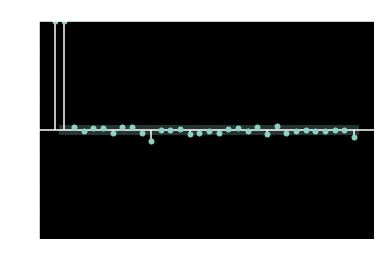

In [15]:
if 'date' in df_oil.columns:
    df_oil['date'] = pd.to_datetime(df_oil['date'] , format="%Y-%m-%d")
    df_oil = df_oil.set_index('date').asfreq('D').fillna(method="bfill")
plot_pacf(df_oil.dcoilwtico, lags = 31)
plt.show()

## store

In [16]:
df_store.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [17]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [18]:
df_store.describe()

,store_nbr,cluster
count,54.000000,54.000000
mean,27.500000,8.481481
std,15.732133,4.693395
min,1.000000,1.000000
25%,14.250000,4.000000
50%,27.500000,8.500000
75%,40.750000,13.000000
max,54.000000,17.000000


## transaction

In [19]:
df_transaction.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [28]:
df_transaction.tail()

,date,store_nbr,transactions
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932
83487,2017-08-15,54,802


In [20]:
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [21]:
df_transaction.describe()

,store_nbr,transactions
count,83488.000000,83488.000000
mean,26.939237,1694.602158
std,15.608204,963.286644
min,1.000000,5.000000
25%,13.000000,1046.000000
50%,27.000000,1393.000000
75%,40.000000,2079.000000
max,54.000000,8359.000000


## train

In [22]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [23]:
df_train.describe()

,id,store_nbr,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00
std,8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02


In [24]:
df_train[df_train['date']=='2013-01-01'].sales.unique()

array([  0.      ,   2.      , 810.      , 180.589   , 186.      ,
       143.      ,  71.09    ,  46.      ,  29.654999, 700.      ,
        15.      ,   5.      , 105.      , 110.801   ,  25.      ,
        42.637   ,  37.847   ])

## test

In [25]:
df_test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [26]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


In [27]:
df_test.describe()

,id,store_nbr,onpromotion
count,2.851200e+04,28512.000000,28512.000000
mean,3.015144e+06,27.500000,6.965383
std,8.230850e+03,15.586057,20.683952
min,3.000888e+06,1.000000,0.000000
25%,3.008016e+06,14.000000,0.000000
50%,3.015144e+06,27.500000,0.000000
75%,3.022271e+06,41.000000,6.000000
max,3.029399e+06,54.000000,646.000000
